In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from myutils import *
from SLBQP import SLBQP
from datastorer import DataStorer
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
params = {
    'figure.figsize': (20, 10),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

In [2]:
def convergence(values, optimal_values):
    tmp = values - optimal_values
    res = []
    for l in tmp:
        res.append(l[1:] / l[:-1])
    return np.array(res)

In [3]:
def load_problems(size, measure='val', alg='goldstein', start_range=0,nproblems=20, maindir='CSV'):
    """extract one column from all the csv of that size and algorithm"""
    prob = "GOLD" if (alg.lower().startswith('g')) or (type(alg) is int and alg == 1) else "ROS"
    path = f"{maindir}/{size}/{prob}/" + "{}.csv"
    problem_values = []
    for i in range(start_range, nproblems):
        filepath = path.format(str(i))
        problem_values.append(pd.read_csv(filepath, usecols=[measure]).to_numpy())
    return problem_values

In [10]:
def load_optimal_values_file(root, size, dataset="ML", filename="optimal_values.txt", verbose=False):
    path = f"RUNS/{dataset}/{root}/{size}/{filename}"
    if verbose:
        print("loading from "+path)
    with open(path, "r") as f:
        lines = f.readlines()
        lines = [np.float64(i.strip()) for i in lines]
        return lines

In [5]:
def get_best_values(dataset, size=600, params="C1EPS01"):
    solver_results = load_optimal_values_file(params, 600, dataset)
    
    gold_opt = load_problems(size, maindir=f"RUNS/{dataset}/{params}")
    gold_opt = np.array([x[-1] for x in gold_opt]).flatten()
    
    optimal_rosen = load_problems(600, maindir=f"RUNS/{dataset}/{params}", alg="Rosen")
    ros_opt = np.array([x[-1] for x in optimal_rosen]).flatten()
    
    assert(len(ros_opt) == len(gold_opt) == len(solver_results))
    
    return np.array([min(x) for x in zip(solver_results, ros_opt, gold_opt)])

In [6]:
def compute_convergence(root, size, dataset, alg):
    optimal = get_best_values(dataset, size, root)
    values = load_problems(str(size), alg=alg, maindir=f"RUNS/{dataset}/{root}")
    conv = convergence(values, optimal)
    return conv

In [7]:
def extract_optimal_values(size):
    """reads the file containing the optimal values and returns an array with the values"""
    assert(size in [i*1e2 for i in range(1,11)])
    lines = None
    path = f"CSV/{size}/optimal_values.txt"
    with open(path, "r") as f:
        lines = f.readlines()
        lines = [np.float(i.strip()) for i in lines]
    return np.array(lines)

def load_problems_measure(size, measure='val', alg='goldstein', start_range=0,nproblems=20, maindir='CSV'):
    """extract one column from all the csv of that size and algorithm"""
    prob = "GOLD" if (alg.lower().startswith('g')) or (type(alg) is int and alg == 1) else "ROS"
    path = f"{maindir}/{size}/{prob}/" + "{}.csv"
    problem_values = []
    for i in range(start_range, nproblems):
        filepath = path.format(str(i))
        problem_values.append(pd.read_csv(filepath, usecols=[measure]).to_numpy())
    return problem_values

#def load_problems(size, measure='val', alg='goldstein', start_range=0,nproblems=20, maindir='RUNS/ML'):
#    """extract one column from all the csv of that size and algorithm"""
#    prob = "GOLD" if (alg.lower().startswith('g')) or (type(alg) is int and alg == 1) else "ROS"
#    path = f"{maindir}/{size}/{prob}/" + "{}.csv"
#    problem_values = []
#    for i in range(start_range, nproblems):
#        filepath = path.format(str(i))
#        problem_values.append(pd.read_csv(filepath, usecols=[measure]).to_numpy())
#    return problem_values

def transform_values(val, opt):
    # TODO caricare valori ottimi
    #opt = val[-1]
    return (val - opt) / np.abs(opt)

In [8]:
rootfolders = "C01EPS01 C10EPS01 C1EPS001 C1EPS01 C1EPS1 C5EPS01".split(" ")
rootdataset = "AIRF CAL ML".split(" ")
problem_sizes = [200,300,400,600]
epsilons = "C1EPS001 C1EPS01 C1EPS1".split(" ")
upperbounds = "C01EPS01 C1EPS01 C5EPS01 C10EPS01".split(" ")

# ML - UPPERBOUNDS

loading from RUNS/ML/C01EPS01/600/optimal_values.txt
loading from RUNS/ML/C01EPS01/600/optimal_values.txt
loading from RUNS/ML/C01EPS01/600/optimal_values.txt
loading from RUNS/ML/C1EPS01/600/optimal_values.txt
loading from RUNS/ML/C1EPS01/600/optimal_values.txt
loading from RUNS/ML/C1EPS01/600/optimal_values.txt
loading from RUNS/ML/C5EPS01/600/optimal_values.txt
loading from RUNS/ML/C5EPS01/600/optimal_values.txt
loading from RUNS/ML/C5EPS01/600/optimal_values.txt
loading from RUNS/ML/C10EPS01/600/optimal_values.txt
loading from RUNS/ML/C10EPS01/600/optimal_values.txt
loading from RUNS/ML/C10EPS01/600/optimal_values.txt


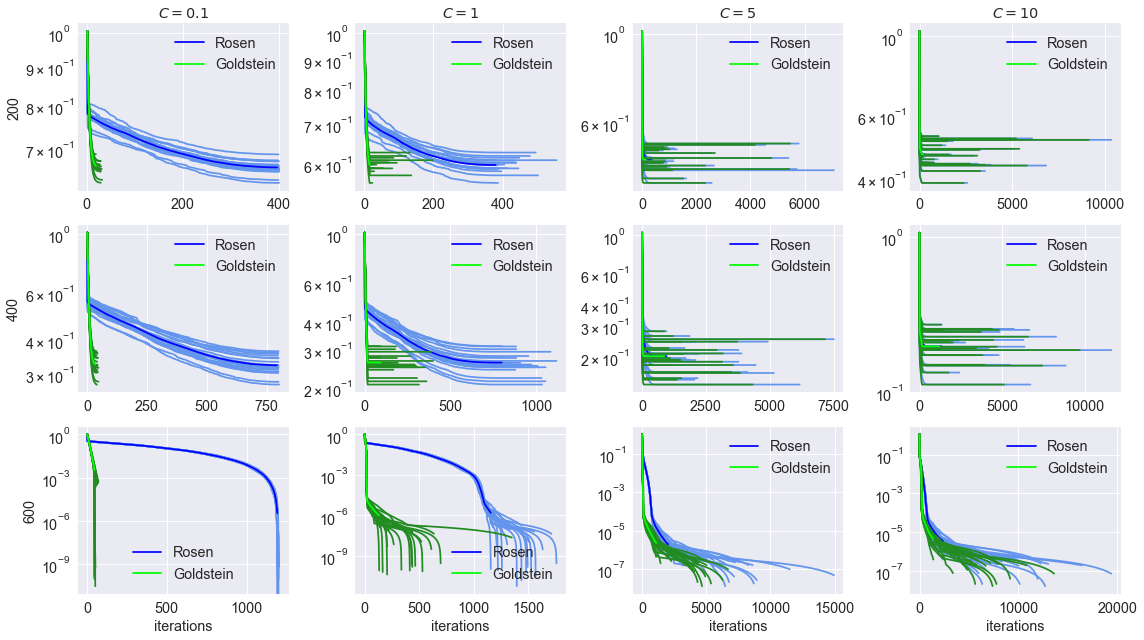

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,9))
sizes = [200,400,600]
chosen_uppers = upperbounds
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=f"RUNS/ML/{root}", nproblems=20)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=f"RUNS/ML/{root}", nproblems=20)
        
        best_values = get_best_values(dataset="ML", size=size, params=root)
        
        values_rosen = [transform_values(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [transform_values(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_yscale("symlog")
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[2]:
    ax.set_xlabel("iterations")



plt.tight_layout()

# AIRFOIL - Upperbounds

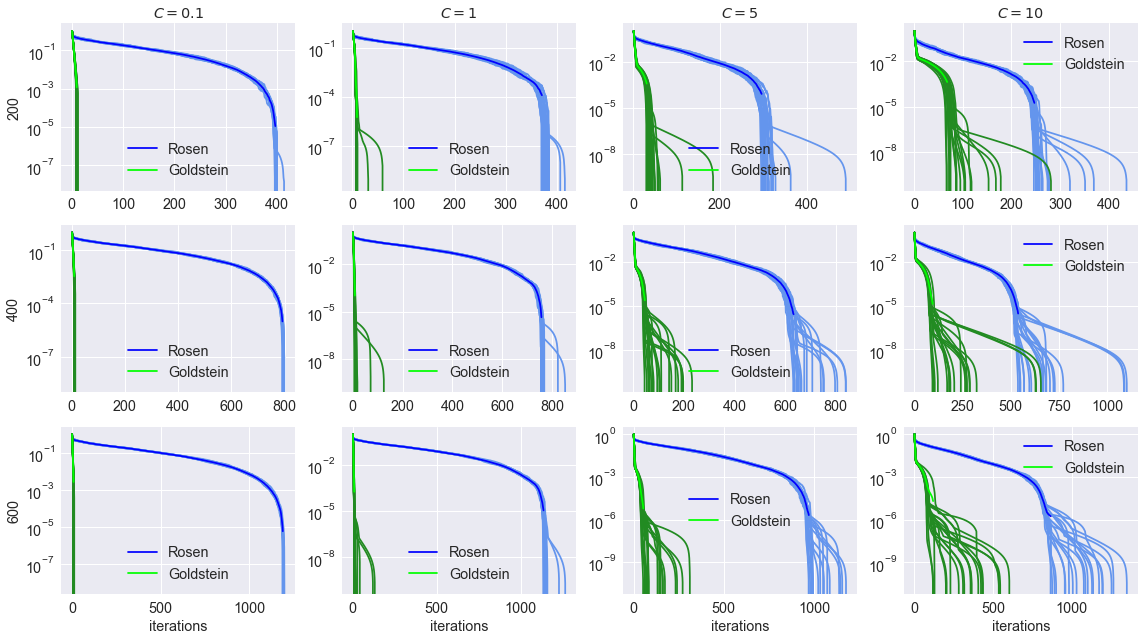

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,9))
#sizes = [*range(100,700,100)]
sizes = [200,400,600]
chosen_uppers = upperbounds
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=f"RUNS/AIRF/{root}", nproblems=20)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=f"RUNS/AIRF/{root}", nproblems=20)
        
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_yscale("symlog")
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[2]:
    ax.set_xlabel("iterations")



plt.tight_layout()

# CALIFORNIA HOUSING - UPPERBOUNDS

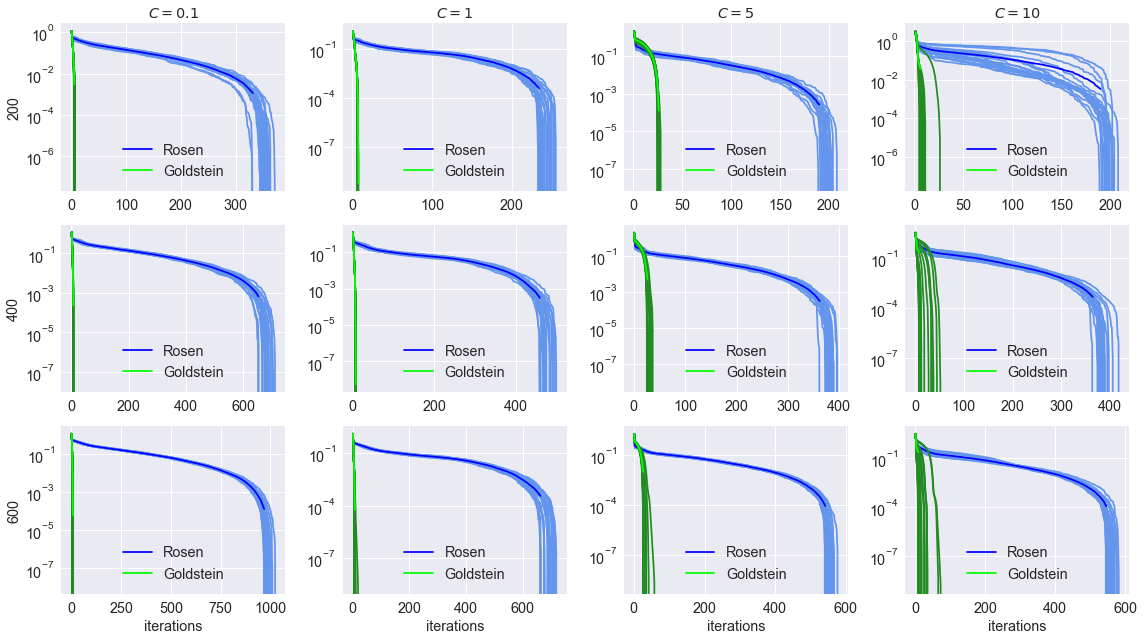

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,9))
#sizes = [*range(100,700,100)]
sizes = [200,400,600]
chosen_uppers = upperbounds
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=f"RUNS/CAL/{root}", nproblems=20)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=f"RUNS/CAL/{root}", nproblems=20)
        
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_yscale("symlog")
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[2]:
    ax.set_xlabel("iterations")



plt.tight_layout()

# ML - $\epsilon$

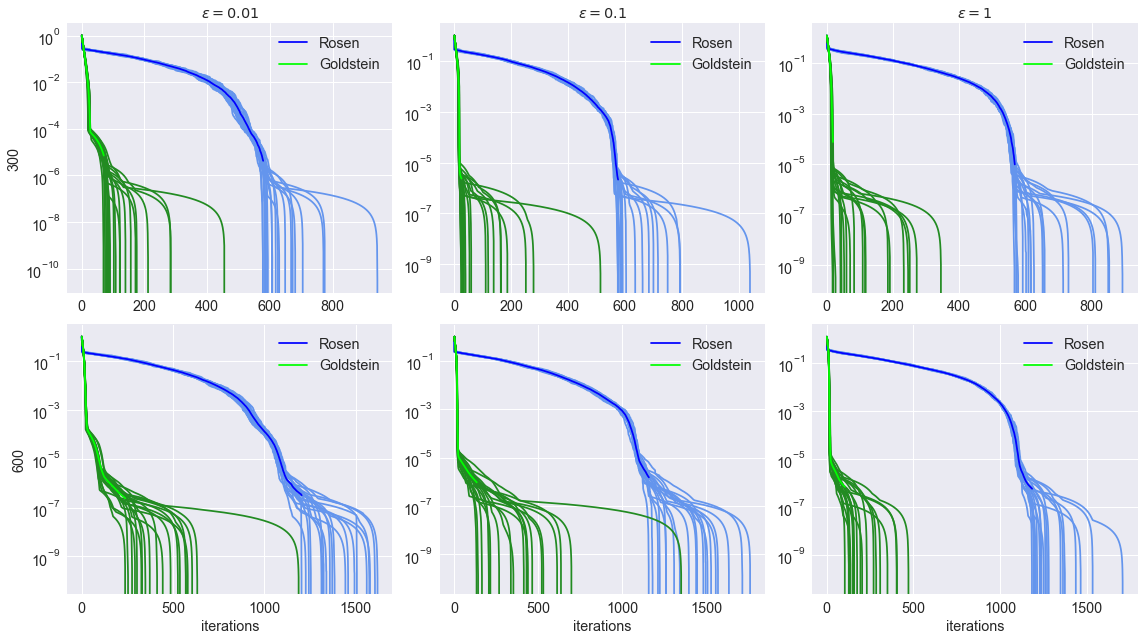

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
sizes = [300,600]

ml_eps = ['RUNS/ML/'+i for i in epsilons]
for i,root in enumerate(ml_eps):
    for j,size in enumerate(sizes):
        ax = axs[j][i]
        values_rosen = load_problems(str(size), alg="rosen", maindir=root)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root)
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))

for ax, eps in zip(axs[0], [0.01, 0.1, 1]):
    ax.set_title(f"$\epsilon = {eps}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



m, M = axs[0][0].get_ylim()
#for ax in axs[0]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')
m, M = axs[1][0].get_ylim()
#for ax in axs[1]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')

plt.tight_layout()

# AIRFOIL - $\epsilon$

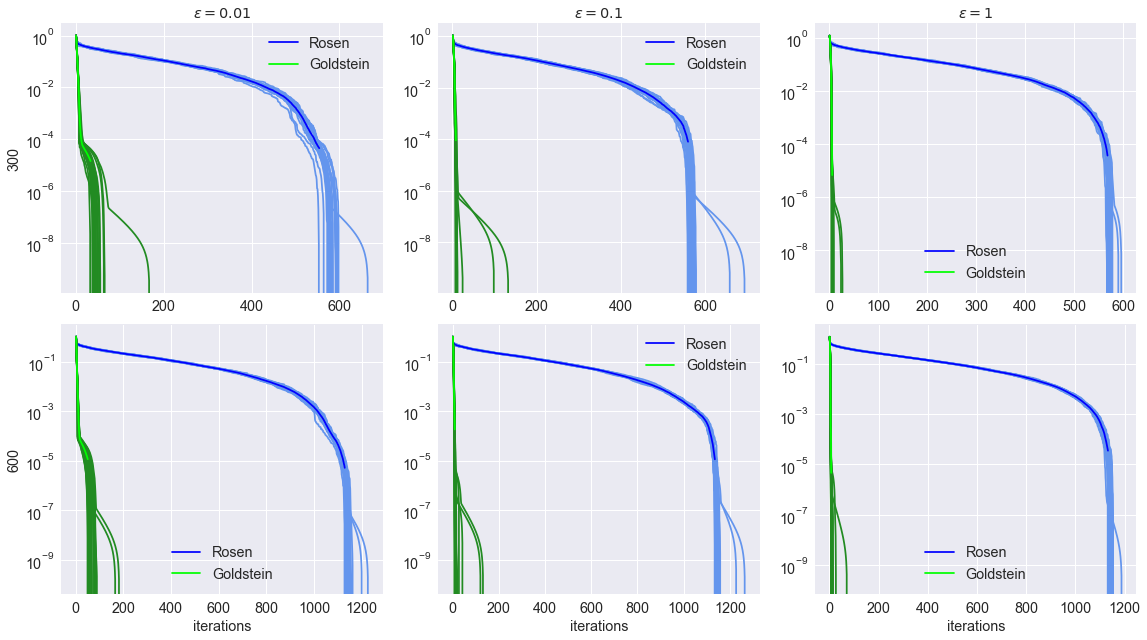

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
sizes = [300,600]

airf_eps = ['RUNS/AIRF/'+i for i in epsilons]
for i,root in enumerate(airf_eps):
    for j,size in enumerate(sizes):
        ax = axs[j][i]
        values_rosen = load_problems(str(size), alg="rosen", maindir=root)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root)
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, eps in zip(axs[0], [0.01, 0.1, 1]):
    ax.set_title(f"$\epsilon = {eps}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



m, M = axs[0][0].get_ylim()
#for ax in axs[0]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')
m, M = axs[1][0].get_ylim()
#for ax in axs[1]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')

plt.tight_layout()

# CALIFORNIA - $\epsilon$

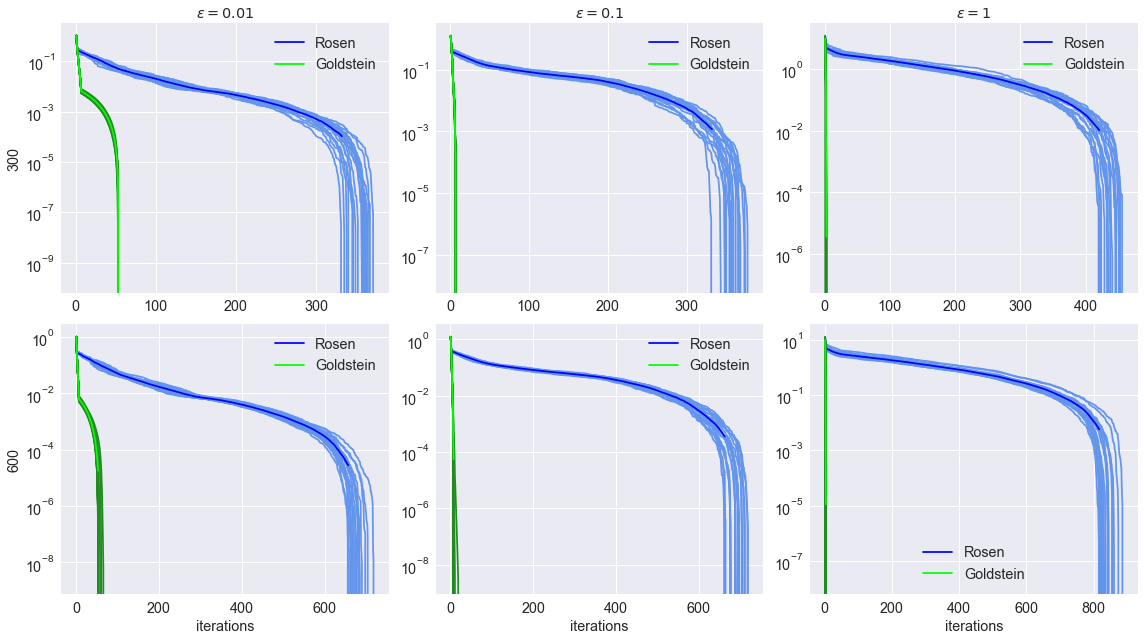

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
sizes = [300,600]

california_eps = ['RUNS/CAL/'+i for i in epsilons]
for i,root in enumerate(california_eps):
    for j,size in enumerate(sizes):
        ax = axs[j][i]
        values_rosen = load_problems(str(size), alg="rosen", maindir=root)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root)
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, eps in zip(axs[0], [0.01, 0.1, 1]):
    ax.set_title(f"$\epsilon = {eps}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



m, M = axs[0][0].get_ylim()
#for ax in axs[0]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')
m, M = axs[1][0].get_ylim()
#for ax in axs[1]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')

plt.tight_layout()

# GRAFICI SEPARATI

In [13]:
def load_problems_from_path(size, measure='val', start_range=0,nproblems=20, path=""):
    """extract one column from all the csv of that size and algorithm"""
    path = path
    problem_values = []
    for i in range(start_range, nproblems):
        filepath = path + f"/{i}.csv"
        problem_values.append(pd.read_csv(filepath, usecols=[measure]).to_numpy())
    return problem_values

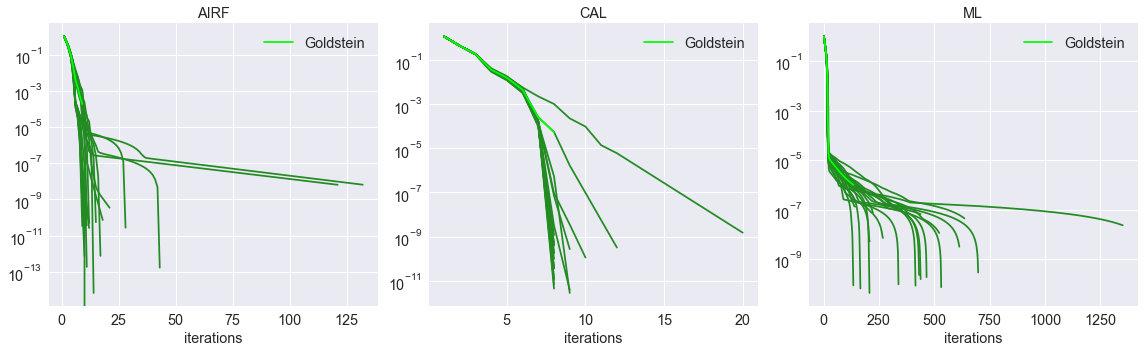

In [14]:
ALG = "GOLD"
fig, axs = plt.subplots(ncols=3, figsize=(16,5))
sizes = [600]
data = [f"RUNS/{i}/C1EPS01/600/{ALG}" for i in rootdataset]
for i,root in enumerate(data):
    for j,size in enumerate(sizes):
        ax = axs[i]
        
        r, ds, root_, s_, alg = root.split('/')
        best_values = get_best_values(dataset=ds, size=size, params=root_)
        
        values =  load_problems_from_path(str(size), path=root)
        values_transformed = [transform_values(i, opt) for i, opt in zip(values, best_values)]
        
        plot_multiple_functions(values_transformed, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        ax.set_yscale("log")
        
for ax in axs:
    ax.set_xlabel("iterations")

for (ax, title) in zip(axs, rootdataset):
    ax.set_title(title)

plt.tight_layout()

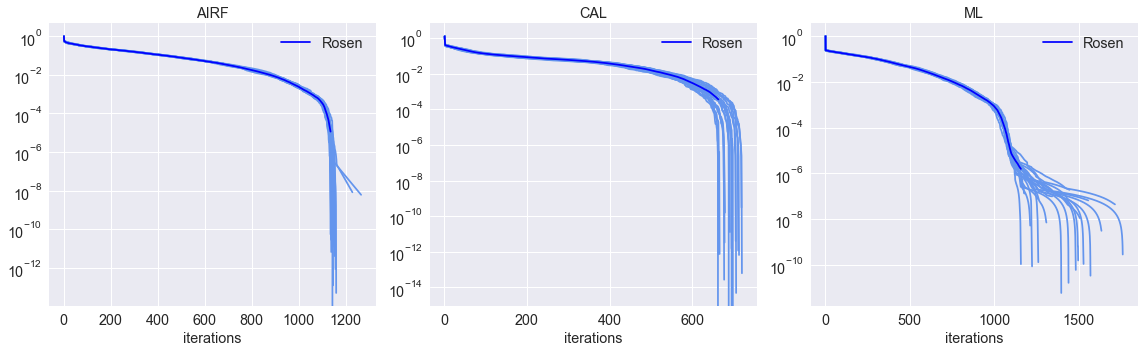

In [15]:
ALG = "ROS"
fig, axs = plt.subplots(ncols=3, figsize=(16,5))
sizes = [600]
data = [f"RUNS/{i}/C1EPS01/600/{ALG}" for i in rootdataset]
for i,root in enumerate(data):
    for j,size in enumerate(sizes):
        ax = axs[i]
        r, ds, root_, s_, alg = root.split('/')
        best_values = get_best_values(dataset=ds, size=size, params=root_)
        
        values =  load_problems_from_path(str(size), path=root)
        values_transformed = [transform_values(i, opt) for i, opt in zip(values, best_values)]
        plot_multiple_functions(values_transformed, plot_avg=True, ax=ax,label="Rosen")
        ax.set_yscale("log")
        
for ax in axs:
    ax.set_xlabel("iterations")

for (ax, title) in zip(axs, rootdataset):
    ax.set_title(title)

plt.tight_layout()

# CONVERGENCE RESULTS

In [16]:
# TODO generare convergenza con valori ottimi presi dal file

In [17]:
epsilons

['C1EPS001', 'C1EPS01', 'C1EPS1']

In [18]:
upperbounds

['C01EPS01', 'C1EPS01', 'C5EPS01', 'C10EPS01']

In [19]:
convergence_ml_gold = compute_convergence("C1EPS01", 600, "ML", "g")
convergence_ml_ros = compute_convergence("C1EPS01", 600, "ML", "r")

convergence_airf_gold = compute_convergence("C1EPS01", 600, "AIRF", "g")
convergence_airf_ros = compute_convergence("C1EPS01", 600, "AIRF", "r")

convergence_cal_gold = compute_convergence("C1EPS01", 600, "CAL", "g")
convergence_cal_ros = compute_convergence("C1EPS01", 600, "CAL", "r")

In [21]:
size = 600
root = 'RUNS/AIRF/C1EPS01'
_, dataset, root_ = root.split('/')
best_values = get_best_values(dataset, size, root_)
values =  load_problems(str(size), alg="goldstein", maindir=root, nproblems=20)
#conv = convergence(values, optimal_values)
values_goldstein = [transform_values(i, opt) for i, opt in zip(values, best_values)]

In [25]:
size=600
root = "RUNS/CAL/C1EPS01"
_, dataset, root_ = root.split('/')
best_values = get_best_values(dataset, size, root_)
values =  load_problems(str(size), alg="goldstein", maindir=root, nproblems=20)
values_rosen = [transform_values(i, opt) for i, opt in zip(values, best_values)]

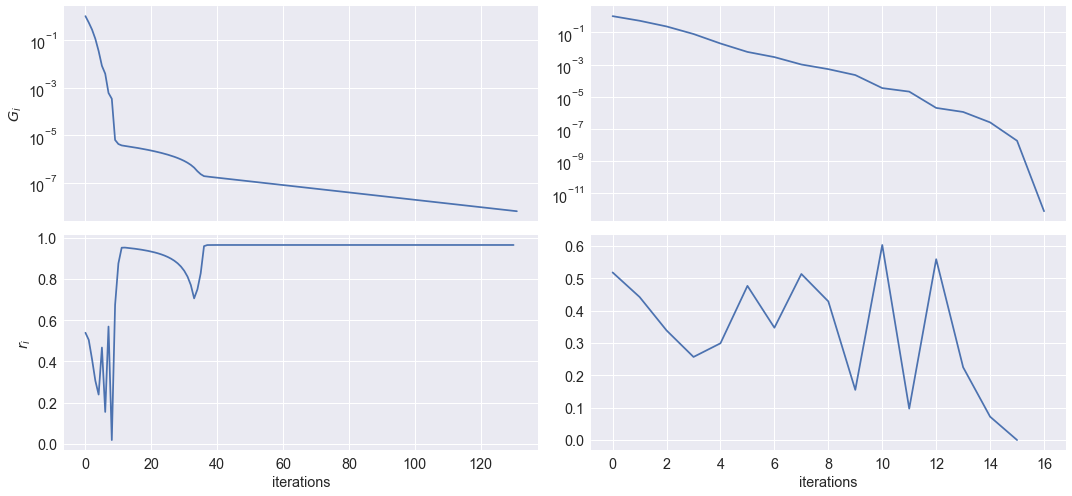

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", figsize=(15,7))
conv = convergence_airf_gold
####
idx = 13
axs[0][0].plot(range(len(values_goldstein[idx])), values_goldstein[idx])
axs[0][0].set_yscale("log")
axs[1][0].plot(range(len(conv[idx])), conv[idx])
####
idx = 18
axs[0][1].plot(range(len(values_goldstein[idx])), values_goldstein[idx])
axs[0][1].set_yscale("log")
axs[1][1].plot(range(len(conv[idx])), conv[idx])
###
axs[1][0].set_xlabel("iterations")
axs[1][1].set_xlabel("iterations")

axs[0][0].set_ylabel("$G_i$")
axs[1][0].set_ylabel("$r_i$")

plt.tight_layout()

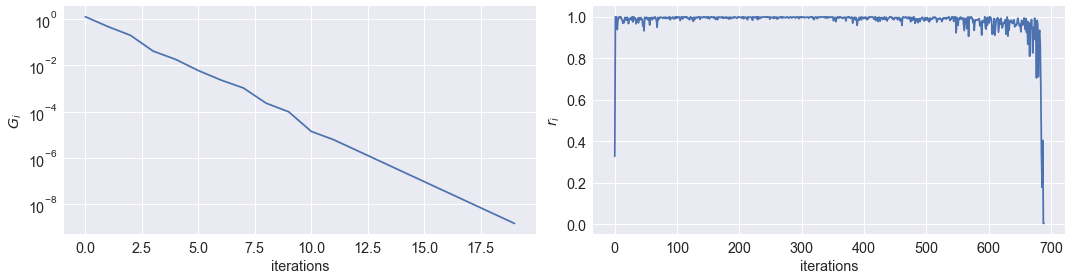

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
conv = convergence_cal_ros
idx = 3
axs[0].plot(range(len(values_rosen[idx])), values_rosen[idx])
axs[0].set_yscale("log")
axs[1].plot(range(len(conv[idx])), conv[idx])

axs[0].set_xlabel("iterations")
axs[1].set_xlabel("iterations")

axs[0].set_ylabel("$G_i$")
axs[1].set_ylabel("$r_i$")

plt.tight_layout()